# **Visualisations**

## Objectives
In this notebook, I will explore and communicate key trends in global video game sales to validate my hypotheses about what drives sales performance.  
I will begin with an overview of **global sales trends**, then create targeted visualisations to test each hypothesis — such as the impact of reviews, regional platform strength, and the effect of multi-platform and first-party releases.

## Inputs
I will use the **processed datasets** created during ETL and feature engineering:

- `video_game_sales_cleaned.csv` — base cleaned dataset with essential sales and metadata.
- `video_game_sales_critic_review.csv` — games with valid critic reviews.
- `video_game_sales_user_review.csv` — games with valid user reviews.
- `video_game_sales_merged.csv` — aggregated game-level dataset (platforms merged).
- `video_game_sales_first_party.csv` — dataset with engineered `is_first_party` and `is_multiplatform` columns.

## Outputs
- Visualisations that support each hypothesis:
  - **Global sales trends** over time.
  - Impact of **critic reviews** on sales.
  - Impact of **user reviews** on sales.
  - **Platform strength by region** (Nintendo, Sony, Microsoft, Other).
  - **Multi-platform vs single-platform** sales comparison.
  - **First-party vs third-party** sales comparison.
- Charts and summaries for the final Tableau dashboard.

## Approach
Each visualisation ties directly to one of my hypotheses and Kanban board user stories.  
I will start with a **Global Sales Trend** plot to establish market context, then move into deeper hypothesis testing using the processed datasets.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/stephenbeese/GitHub/Video-Game-Sales-Analysis'

Set up the data directories

In [4]:
# Set the file path for the raw data
raw_data_dir = os.path.join(current_dir, 'data/raw')

# Set the file path for the processed data
processed_data_dir = os.path.join(current_dir, 'data/processed')

# Print file paths
print("Raw data directory:", raw_data_dir)
print("Processed data directory:", processed_data_dir)

Raw data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/raw
Processed data directory: /Users/stephenbeese/GitHub/Video-Game-Sales-Analysis/data/processed


# Imports

Import the necessary packages to perform the visualisation process.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the csv files into dataframes

In [7]:
df_master = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_cleaned.csv'))
df_merged = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_merged.csv'))
df_first_party = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_first_party.csv'))
df_critic_reviews = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_critic_review.csv'))
df_user_reviews = pd.read_csv(os.path.join(processed_data_dir, 'video_game_sales_user_review.csv'))

### You can view these dataframes [here](display_data.ipynb)

---

# Global Overview

### Global Sales Trends Over Time
- Plot total `Global_Sales` by `Year_of_Release`.
- Highlight peaks (e.g. Wii/DS era, PlayStation boom).
- Optional: stacked bars/area chart by platform family.

In [ ]:
# Aggregate global sales by year
global_sales_by_year = (
    df_master.groupby('Year_of_Release')['Global_Sales']
    .sum()
    .reset_index()
    .sort_values(by='Year_of_Release')
)

# filter out invalid years
global_sales_by_year = global_sales_by_year[global_sales_by_year['Year_of_Release'] > 0]

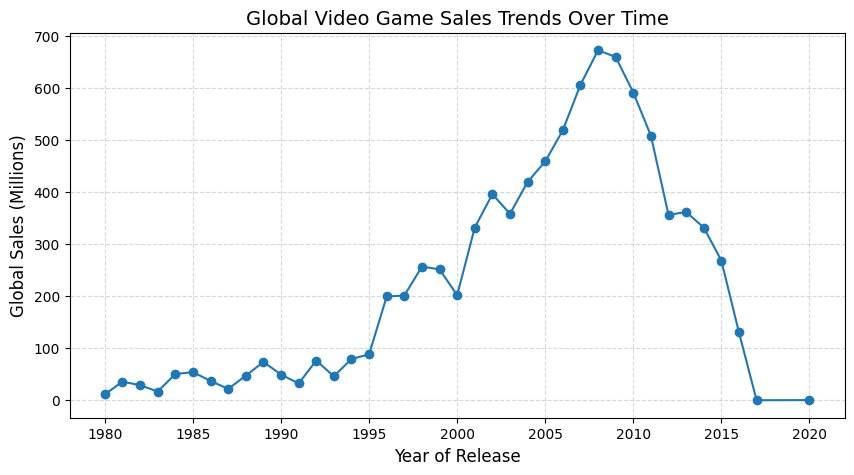

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot global sales over time
plt.figure(figsize=(10, 5))
plt.plot(global_sales_by_year["Year_of_Release"], global_sales_by_year["Global_Sales"], marker="o")
plt.title("Global Video Game Sales Trends Over Time", fontsize=14)
plt.xlabel("Year of Release", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Save the plot
plt.savefig(os.path.join(current_dir, 'images/visualisations/global_sales_trends.png'))

### Insights from Global Sales Trends

* **Steady Growth (1980s–1990s)**
  Sales gradually rose as consoles like NES, SNES, and PlayStation became mainstream.

* **Peak Era (2000–2009)**
  Sharp growth leading to a peak around **2008–2009**, driven by the Wii/DS boom and strong PS3/Xbox 360 releases.

* **Decline After 2009**
  Sales drop steeply — likely due to digital distribution, mobile gaming, and fewer physical releases.

* **Recent Low Volumes (2015+)**
  Physical sales remain low as the market shifts to digital downloads, subscriptions, and live-service games.

---

# **Hypothesis Testing**
---

## Hypothesis 1 — Critic Reviews Drive Sales
- **Data:** `video_game_sales_critic_review.csv`
- **Visual:** Scatter plot of `Critic_Score` vs `Global_Sales`  
  - Regression line  
  - Bubble size = `Critic_Count`
- **Validation:** Look for positive correlation & p-value < 0.05.

---

## Hypothesis 2 — User Reviews Drive Sales

* **Data:** `video_game_sales_user_review.csv`
* **Visual:** Scatter plot of `User_Score` vs `Global_Sales`

  * Regression line
  * Bubble size = `User_Count`
* **Validation:** Look for a positive correlation (p-value < 0.05) between user score and global sales.

---

## Hypothesis 3 — Platform Strength by Region

* **Data:** `video_game_sales_cleaned.csv`
* **Visual:** Grouped bar charts of average `JP_Sales`, `NA_Sales`, and `EU_Sales` by platform vendor (Nintendo, Sony, Microsoft, Other).
* **Validation:** Use ANOVA and post-hoc Tukey tests to confirm significant differences between vendors in each region (expect Nintendo highest in Japan, Sony/Microsoft leading in NA and EU).


---

## Hypothesis 4 — Multi-Platform Advantage

* **Data:** `video_game_sales_merged.csv`
* **Visual:** Boxplot or violin plot comparing `Global_Sales` for `is_multiplatform = True` vs `False`.
* **Validation:** Test for a statistically significant difference in sales using Mann–Whitney U or t-test (expect multi-platform games to sell more globally).

---

## Hypothesis 5 — First-Party Advantage

* **Data:** `video_game_sales_first_party.csv`
* **Visual:** Bar charts comparing mean `Global_Sales` for `is_first_party = True` vs `False`, grouped by platform vendor (Nintendo, Sony, Microsoft).
* **Validation:** Use t-test or Mann–Whitney U to check if first-party games significantly outperform third-party titles on their respective platforms.

---

## Dashboard Preparation
- Export any summary tables or aggregated CSVs that will feed into Tableau.
- Note which visuals or KPIs will be highlighted (e.g. average sales per platform, first-party vs third-party performance, critic vs user review impact).

---

## Insights & Next Steps
- Summarise the main findings from each hypothesis test.
- Highlight actionable insights (e.g. “Critic reviews show stronger correlation than user reviews”; “First-party Nintendo titles outperform third-party significantly in Japan”).
- Note next steps (interactive Tableau dashboard build).

---